In [1]:
from report_gui_test import report_gui
# importlib.reload(report_gui)

In [41]:
from ipywidgets import FloatText, HTML
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import requests, io, pytz
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Button, Text, Dropdown, IntText, Output, Select, DatePicker

# EPICS PVs
epics_pvs = {
    "GMD": ("GDET:FEE1:362:ENRC", "#00008B"),        # deep blue
    "XGMD": ("EM2K0:XGMD:HPS:milliJoulesPerPulse", "#8B0000"),  # dark red
}

# Hutch color mapping
hutch_colors = {
    "XCS": "purple",
    "CXI": "red",
    "MFX": "orange",
    "MEC": "yellow",
    "TXI": "magenta",
    "TMO": "blue",
    "RIX": "#B99A7B",
    "MD" : "gray",
}

# Hutch calendar URLs
hutch_calendars = {
    "TMO": "https://www.google.com/calendar/ical/tauubmn9n6evkir835i4uqde3c%40group.calendar.google.com/public/basic.ics",
    "TXI": "https://www.google.com/calendar/ical/ag90tn65tk169kgpkt8i7286ns%40group.calendar.google.com/public/basic.ics",
    "XPP": "https://www.google.com/calendar/ical/6sr414nehbugn2k67efq71mppg%40group.calendar.google.com/public/basic.ics",
    "RIX": "https://calendar.google.com/calendar/ical/rf402b8ts02ultfjc62l8clalk%40group.calendar.google.com/public/basic.ics",
    "XCS": "https://www.google.com/calendar/ical/ljjr3de15ianjh42ahlqvcv5s4%40group.calendar.google.com/public/basic.ics",
    "MFX": "https://www.google.com/calendar/ical/lun28fjakluvivt5q4fj6qu2eg%40group.calendar.google.com/public/basic.ics",
    "CXI": "https://www.google.com/calendar/ical/lt8askfj7kivnsfki1dgc63ifs%40group.calendar.google.com/public/basic.ics",
    "MEC": "https://www.google.com/calendar/ical/nka5r8ffmrik5jcdih8nu73r1k%40group.calendar.google.com/public/basic.ics"
}

# ics 파싱
def parse_dt(dt_str):
    if dt_str.endswith("Z"):
        return datetime.strptime(dt_str, "%Y%m%dT%H%M%SZ")
    elif "T" in dt_str:
        return datetime.strptime(dt_str, "%Y%m%dT%H%M%S")
    else:
        return datetime.strptime(dt_str, "%Y%m%d")

def load_hutch_patches(hutch_name, url, start_dt=None, end_dt=None, tz="America/Los_Angeles"):
    r = requests.get(url)
    r.raise_for_status()
    lines = r.text.splitlines()
    patches = []
    inside_event, event = False, {}
    for line in lines:
        if line.startswith("BEGIN:VEVENT"):
            inside_event, event = True, {}
        elif line.startswith("END:VEVENT"):
            inside_event = False
            if "DTSTART" in event and "DTEND" in event:
                start = parse_dt(event["DTSTART"])
                end = parse_dt(event["DTEND"])
                start = pytz.UTC.localize(start).astimezone(pytz.timezone(tz)) if start.tzinfo is None else start
                end = pytz.UTC.localize(end).astimezone(pytz.timezone(tz)) if end.tzinfo is None else end
                if start_dt and end_dt:
                    if end < start_dt or start > end_dt:
                        continue
                minutes = int((end - start).total_seconds() / 60)
                patches.append((start.strftime("%Y-%m-%d %H:%M"), minutes, hutch_name))
        elif inside_event:
            if line.startswith("DTSTART"):
                event["DTSTART"] = line.split(":", 1)[1]
            elif line.startswith("DTEND"):
                event["DTEND"] = line.split(":", 1)[1]
    return patches

# PV 데이터 fetch
def fetch_pv_data_as_df(pv: str, start: str, end: str):
    url = f"https://pswww.slac.stanford.edu/archiveviewer/retrieval/data/getData.csv?pv={pv}&from={start}&to={end}"
    r = requests.get(url)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), header=None, names=["Timestamp", "Value1", "Value2", "Value3", "Value4"])
    df = df[pd.to_numeric(df["Timestamp"], errors='coerce').notnull()]
    df["Timestamp"] = pd.to_datetime(df["Timestamp"].astype(float), unit='s')
    df["Timestamp"] = df["Timestamp"].dt.tz_localize("UTC").dt.tz_convert("America/Los_Angeles")
    df["Value1"] = pd.to_numeric(df["Value1"], errors='coerce')
    return df

# 보고서 및 plot
def report_range(end_date: str, period: str, hutch_patches=[], comment_patches=[], threshold=None, xgmd_threshold=None):
    tz = pytz.timezone("America/Los_Angeles")
    try:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M")
    end_dt = tz.localize(end_dt)
    if period.endswith('d'):
        delta = timedelta(days=int(period[:-1]))
    elif period.endswith('h'):
        delta = timedelta(hours=int(period[:-1]))
    else:
        raise ValueError("period is 'Nd' or 'Nh.")
    start_dt = end_dt - delta
    start_time = start_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    end_time   = end_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    
    gmd_df = fetch_pv_data_as_df(epics_pvs["GMD"][0], start_time, end_time).iloc[::5]
    xgmd_df = fetch_pv_data_as_df(epics_pvs["XGMD"][0], start_time, end_time).iloc[::5]

    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,8), sharex=False)
    
    # PV plot
    ax1.plot(gmd_df["Timestamp"], gmd_df["Value1"], 'o', alpha=0.1, ms=1, color=epics_pvs["GMD"][1], label="GMD")
    ax2.plot(xgmd_df["Timestamp"], xgmd_df["Value1"], 'o', alpha=0.1, ms=1, color=epics_pvs["XGMD"][1], label="XGMD")
    ax1.set_ylabel("GMD (mJ)"); ax2.set_ylabel("XGMD (mJ)"); ax2.set_xlabel("Time")
    ax1.set_ylim([-0.4,3]); ax2.set_ylim([-0.4,3])
    ax1.grid(True); ax2.grid(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=tz))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=tz))
    fig.autofmt_xdate()
    
    # patch
    patch_ymin, patch_ymax = -0.4, -0.2
    comment_patch_ymin, comment_patch_ymax = 0,3
    table_data=[]
    
    for ax in [ax1, ax2]:
        for start_str, minutes, hutch in hutch_patches:
            start_patch = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_patch = start_patch + timedelta(minutes=minutes)
            if start_dt <= end_patch and end_dt >= start_patch:
                color = hutch_colors.get(hutch,'gray')
                if hutch in ["XCS","XPP","CXI","MFX","MEC"]:
                    ax_to_use = ax1
                else:
                    ax_to_use = ax2
                ax_to_use.fill_betweenx([patch_ymin,patch_ymax], start_patch, end_patch, color=color, alpha=0.8)
        # comment patch
        sorted_comments = sorted(comment_patches,key=lambda x: tz.localize(datetime.strptime(x[0], "%Y-%m-%d %H:%M")))
        for i,(start_str, minutes, issue, hutch) in enumerate(sorted_comments,start=1):
            start_comment = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_comment = start_comment + timedelta(minutes=minutes)
            if start_dt <= end_comment and end_dt >= start_comment:
                ax.fill_betweenx([comment_patch_ymin,comment_patch_ymax],start_comment,end_comment,color='gray',alpha=0.2)
                ax.text(start_comment+(end_comment-start_comment)/2,
                        comment_patch_ymin+0.7*(comment_patch_ymax-comment_patch_ymin),
                        str(i), ha='center', va='center', fontsize=10, fontweight='bold')
                if ax is ax2:
                    table_data.append([i,start_str,minutes,issue,hutch])
    if table_data:
        table = ax2.table(cellText=table_data,colLabels=["#","Start","Minutes","Issue","Area"],
                          cellLoc='center',colLoc='center',loc='bottom',bbox=[0,-0.5,1,0.35])
        table.auto_set_font_size(False); table.set_fontsize(10)
    plt.show()
    
    # Threshold 계산
    result_html=""
    if threshold is not None:
        below=len(gmd_df[gmd_df["Value1"]<threshold])*gmd_df["Timestamp"].diff().median().total_seconds()/60
        above=len(gmd_df[gmd_df["Value1"]>=threshold])*gmd_df["Timestamp"].diff().median().total_seconds()/60
        result_html=f"<b>GMD Threshold {threshold} mJ:</b><br>Below: {below:.1f} min<br>Above: {above:.1f} min"
    if xgmd_threshold is not None:
        below_x=len(xgmd_df[xgmd_df["Value1"]<xgmd_threshold])*xgmd_df["Timestamp"].diff().median().total_seconds()/60
        above_x=len(xgmd_df[xgmd_df["Value1"]>=xgmd_threshold])*xgmd_df["Timestamp"].diff().median().total_seconds()/60
        result_html += f"<br><b>XGMD Threshold {xgmd_threshold} mJ:</b><br>Below: {below_x:.1f} min<br>Above: {above_x:.1f} min"
    return result_html

# GUI
def report_gui():
    # End date/time
    end_date_picker = DatePicker(value=datetime.today().date(), description="End date")
    end_time_text = Text(value="06:00:00", description="Time")
    period = Dropdown(options=["1d","7d","8d","9d","14d"], value="7d", description="Period")

    # Hutch list
    hutch_list = Select(options=[], rows=8, description="Hutch List", layout=widgets.Layout(width="600px"))
    hutch_date = Text(value="2025-09-02 06:00", description="Start")
    hutch_minutes = IntText(value=720, description="Minutes")
    hutch_name = Dropdown(options=list(hutch_colors.keys()), value="XCS", description="Hutch")
    add_hutch_btn = Button(description="Add Hutch", button_style="success")
    update_hutch_btn = Button(description="Update", button_style="warning")
    remove_hutch_btn = Button(description="Remove", button_style="danger")
    calendar_sync_btn = Button(description="Calendar Sync", button_style="info")
    
    # Comment list
    comment_list = Select(options=[], rows=4, description="Comments", layout=widgets.Layout(width="600px"))
    comment_date = Text(value="2025-09-03 09:15", description="Start")
    comment_minutes = IntText(value=60, description="Minutes")
    comment_issue = Text(value="Shutter delay", description="Issue")
    comment_hutch = Dropdown(options=list(hutch_colors.keys()), value="CXI", description="Hutch")
    add_comment_btn = Button(description="➕ Add Comment", button_style="info")
    remove_comment_btn = Button(description="Remove", button_style="danger")

    # Threshold
    threshold_input = FloatText(value=0.1, description="GMD Threshold (mJ)")
    xgmd_threshold_input = FloatText(value=0.1, description="XGMD Threshold (mJ)")
    threshold_output = HTML()
    
    out_plot = Output()
    hutch_patches=[]
    comment_patches=[]

    # Hutch list select
    def hutch_select_change(change):
        if hutch_list.value:
            idx = hutch_list.options.index(hutch_list.value)
            start, minutes, name = hutch_patches[idx]
            hutch_date.value, hutch_minutes.value, hutch_name.value = start, minutes, name
    hutch_list.observe(hutch_select_change, names='value')

    # Hutch add/update/remove
    def add_hutch(_):
        hutch_patches.append((hutch_date.value,hutch_minutes.value,hutch_name.value))
        hutch_list.options = [f"{s}, {m} min, {h}" for s,m,h in hutch_patches]
        hutch_list.value = hutch_list.options[-1]
    add_hutch_btn.on_click(add_hutch)
    
    def update_hutch(_):
        if hutch_list.value:
            idx = hutch_list.options.index(hutch_list.value)
            hutch_patches[idx] = (hutch_date.value,hutch_minutes.value,hutch_name.value)
            hutch_list.options = [f"{s}, {m} min, {h}" for s,m,h in hutch_patches]
            hutch_list.value = hutch_list.options[idx]
    update_hutch_btn.on_click(update_hutch)
    
    def remove_hutch(_):
        if hutch_list.value:
            idx = hutch_list.options.index(hutch_list.value)
            hutch_patches.pop(idx)
            hutch_list.options = [f"{s}, {m} min, {h}" for s,m,h in hutch_patches]
            if hutch_list.options:
                hutch_list.value = hutch_list.options[0]
    remove_hutch_btn.on_click(remove_hutch)

    # Comment add/remove
    def add_comment(_):
        comment_patches.append((comment_date.value,comment_minutes.value,comment_issue.value,comment_hutch.value))
        comment_list.options = [f"{s}, {m} min, {i}, {h}" for s,m,i,h in comment_patches]
        comment_list.value = comment_list.options[-1]
    add_comment_btn.on_click(add_comment)
    
    def remove_comment(_):
        if comment_list.value:
            idx = comment_list.options.index(comment_list.value)
            comment_patches.pop(idx)
            comment_list.options = [f"{s}, {m} min, {i}, {h}" for s,m,i,h in comment_patches]
            if comment_list.options:
                comment_list.value = comment_list.options[0]
    remove_comment_btn.on_click(remove_comment)
    
    # Calendar sync
    def calendar_sync_cb(b):
        if end_date_picker.value is None: return
        selected_end = datetime.combine(end_date_picker.value, datetime.strptime(end_time_text.value,"%H:%M:%S").time())
        start_window = selected_end - timedelta(days=7)
        end_window = selected_end + timedelta(days=14)
        new_patches=[]
        for hutch,url in hutch_calendars.items():
            try:
                new_patches.extend(load_hutch_patches(hutch,url,start_dt=start_window,end_dt=end_window))
            except:
                continue
        hutch_patches.clear()
        hutch_patches.extend(new_patches)
        
        # 옵션 갱신
        options_list = [f"{s}, {m} min, {h}" for s,m,h in hutch_patches]
        hutch_list.options = options_list
        if options_list:
            hutch_list.value = options_list[0]
        else:
            hutch_list.value = None

    # Run report
    def run_report(_):
        with out_plot:
            out_plot.clear_output()
            selected_date = end_date_picker.value.strftime("%Y-%m-%d")
            selected_datetime = f"{selected_date} {end_time_text.value}"
            result_html = report_range(
                selected_datetime, period.value,
                hutch_patches=hutch_patches,
                comment_patches=comment_patches,
                threshold=threshold_input.value,
                xgmd_threshold=xgmd_threshold_input.value
            )
            threshold_output.value = result_html

    run_btn = Button(description="Generate Report", button_style="primary")
    run_btn.on_click(run_report)

    return VBox([
        HBox([end_date_picker,end_time_text,period,calendar_sync_btn]),
        HBox([hutch_date,hutch_minutes,hutch_name,add_hutch_btn,update_hutch_btn,remove_hutch_btn]),
        hutch_list,
        HBox([comment_date,comment_minutes,comment_issue,comment_hutch,add_comment_btn,remove_comment_btn]),
        comment_list,
        HBox([threshold_input,xgmd_threshold_input]),
        run_btn,
        out_plot,
        threshold_output
    ])


In [42]:
report_gui()

In [43]:
from ipywidgets import FloatText, HTML
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import requests, io, pytz

import ipywidgets as widgets
from ipywidgets import VBox, HBox, Button, Text, Dropdown, IntText, Output, Select, DatePicker

# --- EPICS PVs ---
epics_pvs = {
    "GMD": ("GDET:FEE1:362:ENRC", "#00008B"),        # deep blue
    "XGMD": ("EM2K0:XGMD:HPS:milliJoulesPerPulse", "#8B0000"),  # dark red
}

# --- Hutch color mapping ---
hutch_colors = {
    "XCS": "purple",
    "CXI": "red",
    "MFX": "orange",
    "MEC": "yellow",
    "TXI": "magenta",
    "MD" : "gray",
}

# --- Hutch ICS URLs ---
hutch_calendars = {
    "TMO": "https://www.google.com/calendar/ical/tauubmn9n6evkir835i4uqde3c%40group.calendar.google.com/public/basic.ics",
    "TXI": "https://www.google.com/calendar/ical/ag90tn65tk169kgpkt8i7286ns%40group.calendar.google.com/public/basic.ics",
    "XPP": "https://www.google.com/calendar/ical/6sr414nehbugn2k67efq71mppg%40group.calendar.google.com/public/basic.ics",
    "RIX": "https://calendar.google.com/calendar/ical/rf402b8ts02ultfjc62l8clalk%40group.calendar.google.com/public/basic.ics",
    "XCS": "https://www.google.com/calendar/ical/ljjr3de15ianjh42ahlqvcv5s4%40group.calendar.google.com/public/basic.ics",
    "MFX": "https://www.google.com/calendar/ical/lun28fjakluvivt5q4fj6qu2eg%40group.calendar.google.com/public/basic.ics",
    "CXI": "https://www.google.com/calendar/ical/lt8askfj7kivnsfki1dgc63ifs%40group.calendar.google.com/public/basic.ics",
    "MEC": "https://www.google.com/calendar/ical/nka5r8ffmrik5jcdih8nu73r1k%40group.calendar.google.com/public/basic.ics"
}

# --- ics 파싱 ---
def parse_dt(dt_str):
    if dt_str.endswith("Z"):
        return datetime.strptime(dt_str, "%Y%m%dT%H%M%SZ")
    elif "T" in dt_str:
        return datetime.strptime(dt_str, "%Y%m%dT%H%M%S")
    else:
        return datetime.strptime(dt_str, "%Y%m%d")

def load_hutch_patches(hutch_name, url, start_dt=None, end_dt=None, tz="America/Los_Angeles"):
    r = requests.get(url)
    r.raise_for_status()
    lines = r.text.splitlines()
    
    patches = []
    inside_event, event = False, {}
    
    for line in lines:
        if line.startswith("BEGIN:VEVENT"):
            inside_event, event = True, {}
        elif line.startswith("END:VEVENT"):
            inside_event = False
            if "DTSTART" in event and "DTEND" in event:
                start = parse_dt(event["DTSTART"])
                end   = parse_dt(event["DTEND"])
                # tz 처리
                start = pytz.UTC.localize(start).astimezone(pytz.timezone(tz)) if start.tzinfo is None else start
                end   = pytz.UTC.localize(end).astimezone(pytz.timezone(tz)) if end.tzinfo is None else end
                if start_dt and end_dt:
                    if end < start_dt or start > end_dt:
                        continue
                minutes = int((end - start).total_seconds() / 60)
                patches.append((start.strftime("%Y-%m-%d %H:%M"), minutes, hutch_name))
        elif inside_event:
            if line.startswith("DTSTART"):
                event["DTSTART"] = line.split(":", 1)[1]
            elif line.startswith("DTEND"):
                event["DTEND"] = line.split(":", 1)[1]
    return patches

# --- PV 데이터 불러오기 ---
def fetch_pv_data_as_df(pv: str, start: str, end: str):
    url = f"https://pswww.slac.stanford.edu/archiveviewer/retrieval/data/getData.csv?pv={pv}&from={start}&to={end}"
    r = requests.get(url)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), header=None,
                     names=["Timestamp", "Value1", "Value2", "Value3", "Value4"])
    df = df[pd.to_numeric(df["Timestamp"], errors='coerce').notnull()]
    df["Timestamp"] = pd.to_datetime(df["Timestamp"].astype(float), unit='s')
    df["Timestamp"] = df["Timestamp"].dt.tz_localize("UTC").dt.tz_convert("America/Los_Angeles")
    df["Value1"] = pd.to_numeric(df["Value1"], errors='coerce')
    return df

# --- 리포트/플롯 ---
def report_range(end_date: str, period: str, hutch_patches=[], comment_patches=[], threshold=None):
    tz = pytz.timezone("America/Los_Angeles")
    try:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M")
    end_dt = tz.localize(end_dt)

    if period.endswith('d'):
        delta = timedelta(days=int(period[:-1]))
    elif period.endswith('h'):
        delta = timedelta(hours=int(period[:-1]))
    else:
        raise ValueError("period is 'Nd' or 'Nh.")
    start_dt = end_dt - delta

    start_time = start_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    end_time   = end_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")

    gmd_df = fetch_pv_data_as_df(epics_pvs["GMD"][0], start_time, end_time).iloc[::5]
    xgmd_df = fetch_pv_data_as_df(epics_pvs["XGMD"][0], start_time, end_time).iloc[::5]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=False)

    ax1.plot(gmd_df["Timestamp"], gmd_df["Value1"], 'o', alpha=0.1, ms=1,
             color=epics_pvs["GMD"][1], label="GMD")
    ax1.set_ylabel("GMD (mJ)")
    ax1.set_title(f"Report {start_dt.strftime('%Y-%m-%d')} to {end_dt.strftime('%Y-%m-%d')}")
    ax1.grid(True)
    ax1.set_ylim([-0.4, 3])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=tz))

    ax2.plot(xgmd_df["Timestamp"], xgmd_df["Value1"], 'o', alpha=0.1, ms=1,
             color=epics_pvs["XGMD"][1], label="XGMD")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("XGMD (mJ)")
    ax2.grid(True)
    ax2.set_ylim([-0.4, 3])
    ax2.set_xlim(ax1.get_xlim())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=tz))
    fig.autofmt_xdate()

    patch_ymin, patch_ymax = -0.4, -0.2
    comment_patch_ymin, comment_patch_ymax = 0, 3
    table_data = []

    for ax in [ax1, ax2]:
        for start_str, minutes, hutch in hutch_patches:
            start_patch = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_patch = start_patch + timedelta(minutes=minutes)
            if start_dt <= end_patch and end_dt >= start_patch:
                color = hutch_colors.get(hutch, 'gray')
                ax.fill_betweenx([patch_ymin, patch_ymax], start_patch, end_patch, color=color, alpha=0.8)

        sorted_comments = sorted(comment_patches,
            key=lambda x: tz.localize(datetime.strptime(x[0], "%Y-%m-%d %H:%M"))
        )
        for i, (start_str, minutes, issue, hutch) in enumerate(sorted_comments, start=1):
            start_comment = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_comment = start_comment + timedelta(minutes=minutes)
            if start_dt <= end_comment and end_dt >= start_comment:
                ax.fill_betweenx([comment_patch_ymin, comment_patch_ymax],
                                 start_comment, end_comment,
                                 color='gray', alpha=0.2)
                ax.text(start_comment + (end_comment - start_comment)/2,
                        comment_patch_ymin + 0.7*(comment_patch_ymax - comment_patch_ymin),
                        str(i), ha='center', va='center', fontsize=10, fontweight='bold')
                if ax is ax2:
                    table_data.append([i, start_str, minutes, issue, hutch])

    if table_data:
        table = ax2.table(cellText=table_data,
                         colLabels=["#", "Start", "Minutes", "Issue", "Area"],
                         cellLoc='center', colLoc='center',
                         loc='bottom', bbox=[0, -0.5, 1, 0.35])
        table.auto_set_font_size(False)
        table.set_fontsize(10)

    plt.show()

    result_html = ""
    if threshold is not None:
        below = gmd_df[gmd_df["Value1"] < threshold]
        above = gmd_df[gmd_df["Value1"] >= threshold]
        dt = gmd_df["Timestamp"].diff().median().total_seconds() if len(gmd_df) > 1 else 0
        below_minutes = len(below) * dt / 60
        above_minutes = len(above) * dt / 60
        result_html = f"<b>GMD Threshold {threshold} mJ:</b><br>Below: {below_minutes:.1f} min<br>Above: {above_minutes:.1f} min"

    return result_html

# --- GUI ---
def report_gui():
    end_date_picker = DatePicker(value=datetime.today().date(), description="End date")
    end_time_text = Text(value="06:00:00", description="Time")
    period = Dropdown(options=["1d","7d","8d","9d","14d"], value="7d", description="Period")

    # Hutch patch 입력/리스트
    hutch_list_widget = Select(options=[], rows=6, description="Hutch List", layout=widgets.Layout(width="600px"))
    comment_list_widget = Select(options=[], rows=4, description="Comments", layout=widgets.Layout(width="600px"))

    # GMD Threshold
    threshold_input = FloatText(value=0.1, description="GMD Threshold (mJ)")
    threshold_output = HTML()
    out_plot = Output()

    # --- 자동 허치 로드 ---
    tz = pytz.timezone("America/Los_Angeles")
    today = datetime.now(tz)
    start_window = today - timedelta(days=7)
    end_window   = today + timedelta(days=14)

    hutch_patches = []
    for hutch, url in hutch_calendars.items():
        hutch_patches.extend(load_hutch_patches(hutch, url, start_dt=start_window, end_dt=end_window))

    hutch_list_widget.options = [f"{s}, {m} min, {h}" for s,m,h in hutch_patches]

    # --- Run report 콜백 ---
    def run_report(_):
        with out_plot:
            out_plot.clear_output()
            selected_date = end_date_picker.value.strftime("%Y-%m-%d")
            selected_datetime = f"{selected_date} {end_time_text.value}"
            result_html = report_range(
                selected_datetime, period.value,
                hutch_patches=hutch_patches,
                comment_patches=[],   # 수동 comment만
                threshold=threshold_input.value
            )
            threshold_output.value = result_html

    run_btn = Button(description="Generate Report", button_style="primary")
    run_btn.on_click(run_report)

    return VBox([
        HBox([end_date_picker, end_time_text, period]),
        threshold_input,
        hutch_list_widget,
        comment_list_widget,
        run_btn,
        out_plot,
        threshold_output
    ])


In [44]:
report_gui()

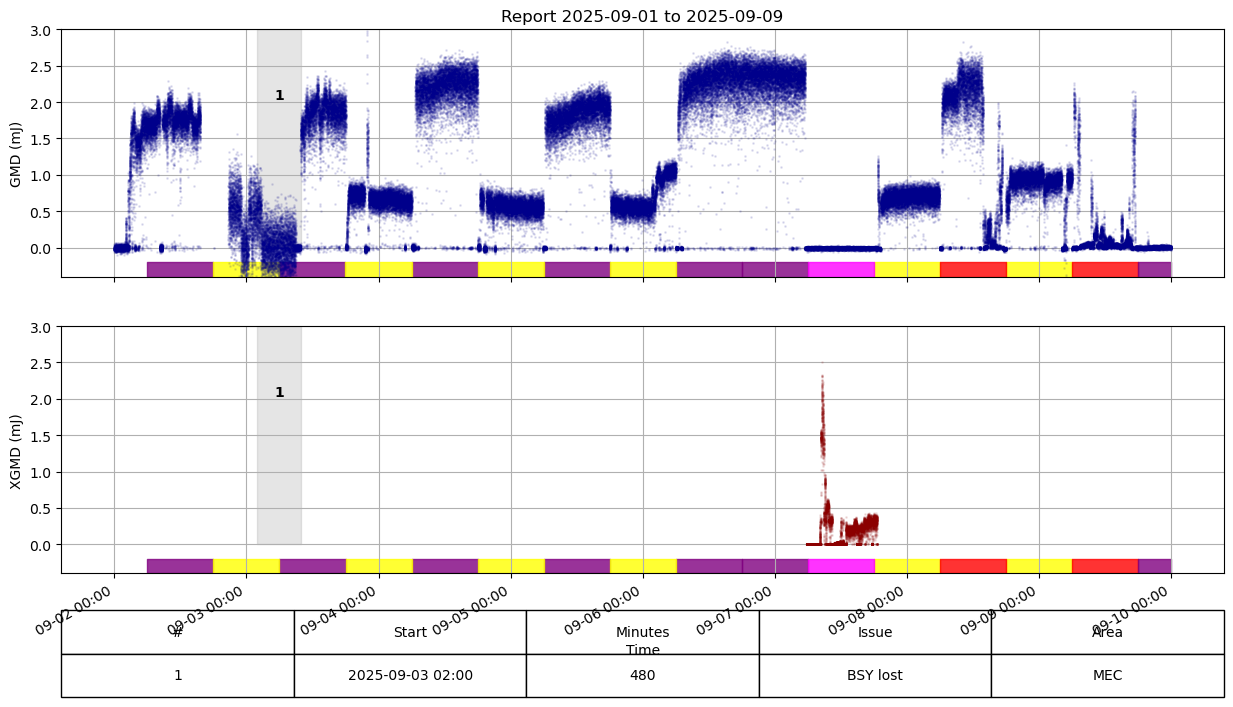

''

In [20]:
%matplotlib inline
hutch_patches = [
    ("2025-09-02 06:00", 60*12, "XCS"),
    ("2025-09-03 06:00", 60*12, "XCS"),
    ("2025-09-04 06:00", 60*12, "XCS"),
    ("2025-09-05 06:00", 60*12, "XCS"),
    ("2025-09-06 06:00", 60*12, "XCS"),
    ("2025-09-06 18:00", 60*12, "XCS"),
    ("2025-09-02 18:00", 60*12, "MEC"),
    ("2025-09-03 18:00", 60*12, "MEC"),
    ("2025-09-04 18:00", 60*12, "MEC"),
    ("2025-09-05 18:00", 60*12, "MEC"),
    ("2025-09-07 18:00", 60*12, "MEC"),
    ("2025-09-08 18:00", 60*12, "MEC"),
    ("2025-09-08 06:00", 60*12, "CXI"),
    ("2025-09-09 06:00", 60*12, "CXI"),
    ("2025-09-09 18:00", 60*6, "XCS"),

    ("2025-09-07 06:00", 60*12, "TXI"),
  
]

comment_patches = [
    ("2025-09-03 02:00", 60*8, "BSY lost", "MEC"),
]

report_range("2025-09-09 23:59", "8d", hutch_patches=hutch_patches, comment_patches=comment_patches)

In [20]:
from report_gui_test import report_gui
reload(report_gui_test)

NameError: name 'reload' is not defined

In [1]:
import requests, io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pytz
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Button, Text, Dropdown, IntText, FloatText, HTML, Select, DatePicker, Output

# -----------------------------
# 허치별 ics URL
# -----------------------------
hutch_calendars = {
    "TMO": "https://www.google.com/calendar/ical/tauubmn9n6evkir835i4uqde3c%40group.calendar.google.com/public/basic.ics",
    "TXI": "https://www.google.com/calendar/ical/ag90tn65tk169kgpkt8i7286ns%40group.calendar.google.com/public/basic.ics",
    "XPP": "https://www.google.com/calendar/ical/6sr414nehbugn2k67efq71mppg%40group.calendar.google.com/public/basic.ics",
    "RIX": "https://calendar.google.com/calendar/ical/rf402b8ts02ultfjc62l8clalk%40group.calendar.google.com/public/basic.ics",
    "XCS": "https://www.google.com/calendar/ical/ljjr3de15ianjh42ahlqvcv5s4%40group.calendar.google.com/public/basic.ics",
    "MFX": "https://www.google.com/calendar/ical/lun28fjakluvivt5q4fj6qu2eg%40group.calendar.google.com/public/basic.ics",
    "CXI": "https://www.google.com/calendar/ical/lt8askfj7kivnsfki1dgc63ifs%40group.calendar.google.com/public/basic.ics",
    "MEC": "https://www.google.com/calendar/ical/nka5r8ffmrik5jcdih8nu73r1k%40group.calendar.google.com/public/basic.ics"
}

# -----------------------------
# ics parser
# -----------------------------
def parse_dt(dt_str):
    if dt_str.endswith("Z"):  # UTC
        return datetime.strptime(dt_str, "%Y%m%dT%H%M%SZ")
    elif "T" in dt_str:
        return datetime.strptime(dt_str, "%Y%m%dT%H%M%S")
    else:
        return datetime.strptime(dt_str, "%Y%m%d")

def load_hutch_patches(hutch_name, url, start_dt=None, end_dt=None, tz="America/Los_Angeles"):
    try:
        r = requests.get(url)
        r.raise_for_status()
    except Exception as e:
        print(f"[{hutch_name}] 캘린더 불러오기 실패: {e}")
        return []

    lines = r.text.splitlines()
    patches = []
    inside_event, event = False, {}

    for line in lines:
        if line.startswith("BEGIN:VEVENT"):
            inside_event, event = True, {}
        elif line.startswith("END:VEVENT"):
            inside_event = False
            if "DTSTART" in event and "DTEND" in event:
                start = parse_dt(event["DTSTART"])
                end   = parse_dt(event["DTEND"])
                # timezone 변환
                start = pytz.UTC.localize(start).astimezone(pytz.timezone(tz)) if start.tzinfo is None else start
                end   = pytz.UTC.localize(end).astimezone(pytz.timezone(tz)) if end.tzinfo is None else end
                # 기간 필터링
                if start_dt and end_dt:
                    if end < start_dt or start > end_dt:
                        continue
                minutes = int((end - start).total_seconds()/60)
                patches.append((start.strftime("%Y-%m-%d %H:%M"), minutes, hutch_name))
        elif inside_event:
            if line.startswith("DTSTART"):
                event["DTSTART"] = line.split(":",1)[1]
            elif line.startswith("DTEND"):
                event["DTEND"] = line.split(":",1)[1]
    return patches


# -----------------------------
# GUI
# -----------------------------
def report_gui():
    tz = pytz.timezone("America/Los_Angeles")

    # 날짜 범위
    start_date = Text(value="2025-09-01", description="Start Date:")
    end_date   = Text(value="2025-09-30", description="End Date:")

    # 허치 리스트 (자동)
    hutch_list = SelectMultiple = widgets.SelectMultiple(
        options=[], rows=15, description="Hutch Patches",
        layout=widgets.Layout(width="80%")
    )

    # comment patch (수동)
    comment_date = Text(value="2025-09-03 09:15", description="Start")
    comment_minutes = IntText(value=60, description="Minutes")
    comment_issue = Text(value="Shutter delay", description="Issue")
    comment_hutch = Dropdown(options=list(hutch_calendars.keys()), value="XPP", description="Hutch")
    add_comment_btn = Button(description="Add Comment", button_style="info")
    remove_comment_btn = Button(description="Remove", button_style="danger")
    comment_list = Select(options=[], rows=6, description="Comments", layout=widgets.Layout(width="80%"))
    comment_patches = []

    # 버튼: 허치 스케줄 로드
    def load_hutch_schedules(_):
        try:
            start_dt = tz.localize(datetime.strptime(start_date.value.strip(), "%Y-%m-%d"))
            end_dt   = tz.localize(datetime.strptime(end_date.value.strip(), "%Y-%m-%d"))
        except Exception as e:
            print("날짜 입력 오류:", e)
            return

        patches = []
        for hutch, url in hutch_calendars.items():
            patches.extend(load_hutch_patches(hutch, url, start_dt=start_dt, end_dt=end_dt))
        hutch_list.options = [f"{s}, {m} min, {h}" for s,m,h in sorted(patches)]

    load_btn = Button(description="Load Hutch Schedules", button_style="success")
    load_btn.on_click(load_hutch_schedules)

    # comment patch 콜백
    def add_comment(_):
        comment_patches.append((comment_date.value, comment_minutes.value, comment_issue.value, comment_hutch.value))
        comment_list.options = [f"{i+1}. {s}, {m} min, {issue} ({h})" 
                                for i,(s,m,issue,h) in enumerate(comment_patches)]

    def remove_comment(_):
        if comment_list.index is not None and comment_list.index >= 0:
            del comment_patches[comment_list.index]
            comment_list.options = [f"{i+1}. {s}, {m} min, {issue} ({h})" 
                                    for i,(s,m,issue,h) in enumerate(comment_patches)]

    add_comment_btn.on_click(add_comment)
    remove_comment_btn.on_click(remove_comment)

    display(
        VBox([
            HBox([start_date, end_date, load_btn]),
            hutch_list,
            HBox([comment_date, comment_minutes, comment_issue, comment_hutch, add_comment_btn, remove_comment_btn]),
            comment_list
        ])
    )

# 실행
report_gui()


In [45]:
import requests, io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pytz
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Button, Text, Dropdown, IntText, FloatText, HTML, Select, DatePicker, Output

# -----------------------------
# EPICS PVs
# -----------------------------
epics_pvs = {
    "GMD": ("GDET:FEE1:362:ENRC", "#00008B"),        # deep blue
    "XGMD": ("EM2K0:XGMD:HPS:milliJoulesPerPulse", "#8B0000"),  # dark red
}

# -----------------------------
# Hutch color mapping
# -----------------------------
hutch_colors = {
    "XCS": "purple",
    "CXI": "red",
    "MFX": "orange",
    "MEC": "yellow",
    "TXI": "magenta",
    "MD" : "gray",
}

# -----------------------------
# Hutch ICS URLs
# -----------------------------
hutch_calendars = {
    "TMO": "https://www.google.com/calendar/ical/tauubmn9n6evkir835i4uqde3c%40group.calendar.google.com/public/basic.ics",
    "TXI": "https://www.google.com/calendar/ical/ag90tn65tk169kgpkt8i7286ns%40group.calendar.google.com/public/basic.ics",
    "XPP": "https://www.google.com/calendar/ical/6sr414nehbugn2k67efq71mppg%40group.calendar.google.com/public/basic.ics",
    "RIX": "https://www.google.com/calendar/ical/rf402b8ts02ultfjc62l8clalk%40group.calendar.google.com/public/basic.ics",
    "XCS": "https://www.google.com/calendar/ical/ljjr3de15ianjh42ahlqvcv5s4%40group.calendar.google.com/public/basic.ics",
    "MFX": "https://www.google.com/calendar/ical/lun28fjakluvivt5q4fj6qu2eg%40group.calendar.google.com/public/basic.ics",
    "CXI": "https://www.google.com/calendar/ical/lt8askfj7kivnsfki1dgc63ifs%40group.calendar.google.com/public/basic.ics",
    "MEC": "https://www.google.com/calendar/ical/nka5r8ffmrik5jcdih8nu73r1k%40group.calendar.google.com/public/basic.ics"
}

# -----------------------------
# ics parser
# -----------------------------
def parse_dt(dt_str):
    if dt_str.endswith("Z"):  # UTC
        return datetime.strptime(dt_str, "%Y%m%dT%H%M%SZ")
    elif "T" in dt_str:
        return datetime.strptime(dt_str, "%Y%m%dT%H%M%S")
    else:
        return datetime.strptime(dt_str, "%Y%m%d")

def load_hutch_patches(hutch_name, url, start_dt=None, end_dt=None, tz="America/Los_Angeles"):
    try:
        r = requests.get(url)
        r.raise_for_status()
    except Exception as e:
        print(f"[{hutch_name}] 캘린더 불러오기 실패: {e}")
        return []

    lines = r.text.splitlines()
    patches = []
    inside_event, event = False, {}

    for line in lines:
        if line.startswith("BEGIN:VEVENT"):
            inside_event, event = True, {}
        elif line.startswith("END:VEVENT"):
            inside_event = False
            if "DTSTART" in event and "DTEND" in event:
                start = parse_dt(event["DTSTART"])
                end   = parse_dt(event["DTEND"])
                start = pytz.UTC.localize(start).astimezone(pytz.timezone(tz)) if start.tzinfo is None else start
                end   = pytz.UTC.localize(end).astimezone(pytz.timezone(tz)) if end.tzinfo is None else end
                if start_dt and end_dt:
                    if end < start_dt or start > end_dt:
                        continue
                minutes = int((end - start).total_seconds()/60)
                patches.append((start.strftime("%Y-%m-%d %H:%M"), minutes, hutch_name))
        elif inside_event:
            if line.startswith("DTSTART"):
                event["DTSTART"] = line.split(":",1)[1]
            elif line.startswith("DTEND"):
                event["DTEND"] = line.split(":",1)[1]
    return patches

# -----------------------------
# EPICS PV Data fetch
# -----------------------------
def fetch_pv_data_as_df(pv: str, start: str, end: str):
    url = f"https://pswww.slac.stanford.edu/archiveviewer/retrieval/data/getData.csv?pv={pv}&from={start}&to={end}"
    r = requests.get(url)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), header=None,
                     names=["Timestamp", "Value1", "Value2", "Value3", "Value4"])
    df = df[pd.to_numeric(df["Timestamp"], errors='coerce').notnull()]
    df["Timestamp"] = pd.to_datetime(df["Timestamp"].astype(float), unit='s')
    df["Timestamp"] = df["Timestamp"].dt.tz_localize("UTC").dt.tz_convert("America/Los_Angeles")
    df["Value1"] = pd.to_numeric(df["Value1"], errors='coerce')
    return df

# -----------------------------
# Plotting
# -----------------------------
def plot_gmd_xgmd(end_date: str, period: str, hutch_patches=[], comment_patches=[], threshold=None):
    tz = pytz.timezone("America/Los_Angeles")
    try:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M")
    end_dt = tz.localize(end_dt)

    delta = timedelta(days=int(period[:-1])) if period.endswith('d') else timedelta(hours=int(period[:-1]))
    start_dt = end_dt - delta
    start_time = start_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    end_time   = end_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")

    gmd_df = fetch_pv_data_as_df(epics_pvs["GMD"][0], start_time, end_time).iloc[::5]
    xgmd_df = fetch_pv_data_as_df(epics_pvs["XGMD"][0], start_time, end_time).iloc[::5]

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8), sharex=False)
    ax1.plot(gmd_df["Timestamp"], gmd_df["Value1"], 'o', alpha=0.1, ms=1, color=epics_pvs["GMD"][1])
    ax2.plot(xgmd_df["Timestamp"], xgmd_df["Value1"], 'o', alpha=0.1, ms=1, color=epics_pvs["XGMD"][1])
    ax1.set_ylabel("GMD (mJ)")
    ax2.set_ylabel("XGMD (mJ)")
    ax2.set_xlabel("Time")
    ax1.grid(True); ax2.grid(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=tz))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=tz))
    fig.autofmt_xdate()

    # Hutch patches
    patch_ymin, patch_ymax = -0.4, -0.2
    comment_patch_ymin, comment_patch_ymax = 0, 3
    table_data = []

    for ax in [ax1, ax2]:
        for start_str, minutes, hutch in hutch_patches:
            start_patch = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_patch = start_patch + timedelta(minutes=minutes)
            ax.fill_betweenx([patch_ymin, patch_ymax], start_patch, end_patch, color=hutch_colors.get(hutch,'gray'), alpha=0.8)
        for i, (start_str, minutes, issue, hutch) in enumerate(comment_patches, start=1):
            start_comment = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_comment = start_comment + timedelta(minutes=minutes)
            ax.fill_betweenx([comment_patch_ymin, comment_patch_ymax], start_comment, end_comment, color='gray', alpha=0.2)
            ax.text(start_comment + (end_comment - start_comment)/2, comment_patch_ymin + 0.7*(comment_patch_ymax - comment_patch_ymin),
                    str(i), ha='center', va='center', fontsize=10, fontweight='bold')
            if ax is ax2:
                table_data.append([i, start_str, minutes, issue, hutch])

    if table_data:
        ax2.table(cellText=table_data, colLabels=["#","Start","Minutes","Issue","Hutch"], cellLoc='center', colLoc='center', loc='bottom', bbox=[0,-0.5,1,0.35], fontsize=10)

    plt.show()

    # Threshold 계산
    result_html = ""
    if threshold is not None:
        below = gmd_df[gmd_df["Value1"] < threshold]
        above = gmd_df[gmd_df["Value1"] >= threshold]
        dt = gmd_df["Timestamp"].diff().median().total_seconds() if len(gmd_df) >1 else 0
        below_minutes = len(below)*dt/60
        above_minutes = len(above)*dt/60
        result_html = f"<b>GMD Threshold {threshold} mJ:</b><br>Below: {below_minutes:.1f} min<br>Above: {above_minutes:.1f} min"

    return result_html

# -----------------------------
# GUI 통합
# -----------------------------
def integrated_gui():
    tz = pytz.timezone("America/Los_Angeles")
    out_plot = Output()

    # 날짜
    end_date_picker = DatePicker(value=datetime.today().date(), description="End Date")
    end_time_text = Text(value="06:00:00", description="Time")
    period = Dropdown(options=["1d","7d","14d"], value="7d", description="Period")

    # Threshold
    threshold_input = FloatText(value=0.1, description="GMD Threshold (mJ)")
    threshold_output = HTML()

    # Hutch auto load
    start_date = Text(value="2025-09-01", description="Start Date")
    end_date_range = Text(value="2025-09-30", description="End Date")
    hutch_list_widget = SelectMultiple = widgets.SelectMultiple(options=[], rows=15, description="Hutch Patches", layout=widgets.Layout(width="80%"))
    def load_hutch(_):
        try:
            start_dt = tz.localize(datetime.strptime(start_date.value.strip(), "%Y-%m-%d"))
            end_dt   = tz.localize(datetime.strptime(end_date_range.value.strip(), "%Y-%m-%d"))
        except Exception as e:
            print("날짜 입력 오류:", e)
            return
        patches = []
        for hutch, url in hutch_calendars.items():
            patches.extend(load_hutch_patches(hutch,url,start_dt,end_dt))
        hutch_list_widget.options = [f"{s},{m} min,{h}" for s,m,h in sorted(patches)]
    load_btn = Button(description="Load Hutch Schedules", button_style="success")
    load_btn.on_click(load_hutch)

    # Comment patch 수동
    comment_date = Text(value="2025-09-03 09:15", description="Start")
    comment_minutes = IntText(value=60, description="Minutes")
    comment_issue = Text(value="Shutter delay", description="Issue")
    comment_hutch = Dropdown(options=list(hutch_calendars.keys()), value="XPP", description="Hutch")
    add_comment_btn = Button(description="Add Comment", button_style="info")
    remove_comment_btn = Button(description="Remove", button_style="danger")
    comment_list = Select(options=[], rows=6, description="Comments", layout=widgets.Layout(width="80%"))
    comment_patches = []

    def add_comment(_):
        comment_patches.append((comment_date.value, comment_minutes.value, comment_issue.value, comment_hutch.value))
        comment_list.options = [f"{i+1}. {s},{m} min,{issue} ({h})" for i,(s,m,issue,h) in enumerate(comment_patches)]
    def remove_comment(_):
        if comment_list.index is not None and comment_list.index >=0:
            del comment_patches[comment_list.index]
            comment_list.options = [f"{i+1}. {s},{m} min,{issue} ({h})" for i,(s,m,issue,h) in enumerate(comment_patches)]
    add_comment_btn.on_click(add_comment)
    remove_comment_btn.on_click(remove_comment)

    # Run plot
    def run_plot(_):
        with out_plot:
            out_plot.clear_output()
            selected_dt = f"{end_date_picker.value.strftime('%Y-%m-%d')} {end_time_text.value}"
            hutch_patches = []
            # for opt in hutch_list_widget.options:
            #     s,m,h = opt.split(",")
            #     hutch_patches.append((s,int(m),h))
            # result_html = plot_gmd_xgmd(selected_dt, period.value, hutch_patches=hutch_patches, comment_patches=comment_patches, threshold=threshold_input.value)
            # threshold_output.value = result_html
            for opt in hutch_list_widget.options:
                try:
                    parts = opt.split(",")
                    s = parts[0].strip()
                    m = int(parts[1].replace(" min","").strip())   # '360 min' → 360
                    h = parts[2].strip()
                    hutch_patches.append((s,m,h))
                except Exception as e:
                    print("Option parse error:", opt, e)

    run_btn = Button(description="Generate Report", button_style="primary")
    run_btn.on_click(run_plot)

    display(VBox([
        HBox([end_date_picker, end_time_text, period]),
        HBox([start_date,end_date_range,load_btn]),
        hutch_list_widget,
        HBox([comment_date, comment_minutes, comment_issue, comment_hutch, add_comment_btn, remove_comment_btn]),
        comment_list,
        threshold_input,
        run_btn,
        out_plot,
        threshold_output
    ]))

# 실행
integrated_gui()


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import requests, io, pytz
import re

import ipywidgets as widgets
from ipywidgets import VBox, HBox, Button, Text, Dropdown, IntText, Output, Select, DatePicker

# EPICS PVs
epics_pvs = {
    "GMD": ("GDET:FEE1:362:ENRC", "#00008B"),        # deep blue
    "XGMD": ("EM2K0:XGMD:HPS:milliJoulesPerPulse", "#8B0000"),  # dark red
}

# Hutch color mapping
hutch_colors = {
    "XCS": "purple",
    "CXI": "red",
    "MFX": "orange",
    "MEC": "yellow",
    "TXI": "magenta",
    "TMO": "blue",
    "RIX": "#B99A7B",
    "MD" : "gray",
}

# Hutch calendar URLs
hutch_calendars = {
    "TMO": "https://www.google.com/calendar/ical/tauubmn9n6evkir835i4uqde3c%40group.calendar.google.com/public/basic.ics",
    "TXI": "https://www.google.com/calendar/ical/ag90tn65tk169kgpkt8i7286ns%40group.calendar.google.com/public/basic.ics",
    "XPP": "https://www.google.com/calendar/ical/6sr414nehbugn2k67efq71mppg%40group.calendar.google.com/public/basic.ics",
    "RIX": "https://www.google.com/calendar/ical/rf402b8ts02ultfjc62l8clalk%40group.calendar.google.com/public/basic.ics",
    "XCS": "https://www.google.com/calendar/ical/ljjr3de15ianjh42ahlqvcv5s4%40group.calendar.google.com/public/basic.ics",
    "MFX": "https://www.google.com/calendar/ical/lun28fjakluvivt5q4fj6qu2eg%40group.calendar.google.com/public/basic.ics",
    "CXI": "https://www.google.com/calendar/ical/lt8askfj7kivnsfki1dgc63ifs%40group.calendar.google.com/public/basic.ics",
    "MEC": "https://www.google.com/calendar/ical/nka5r8ffmrik5jcdih8nu73r1k%40group.calendar.google.com/public/basic.ics"
}

# --- ICS 파서 없이 Google Calendar 싱크 ---
def sync_hutch_from_calendar_noics( end_date_str, period_str, hutch_patches):
    tz = pytz.timezone("America/Los_Angeles")
    
    # --- 날짜 계산 ---
    try:
        end_dt = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        end_dt = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M")
    end_dt = tz.localize(end_dt)
    
    if period_str.endswith('d'):
        delta = timedelta(days=int(period_str[:-1]))
    elif period_str.endswith('h'):
        delta = timedelta(hours=int(period_str[:-1]))
    else:
        raise ValueError("period is 'Nd' or 'Nh.")
    start_dt = end_dt - delta
    total_added = 0

    for hutch_name, url in hutch_calendars.items():
        r = requests.get(url)
        r.raise_for_status()
        text = r.text

        # --- VEVENT 파싱 ---
        events = re.findall(r"BEGIN:VEVENT(.*?)END:VEVENT", text, flags=re.DOTALL)
        for ev in events:
            dtstart_match = re.search(r"DTSTART(?:;[^:]*)?:(\d{8}T\d{6}Z)", ev)
            dtend_match   = re.search(r"DTEND(?:;[^:]*)?:(\d{8}T\d{6}Z)", ev)
            if not dtstart_match or not dtend_match:
                continue
            
            ev_start = datetime.strptime(dtstart_match.group(1), "%Y%m%dT%H%M%SZ")
            ev_end   = datetime.strptime(dtend_match.group(1), "%Y%m%dT%H%M%SZ")
            ev_start = pytz.utc.localize(ev_start).astimezone(tz)
            ev_end   = pytz.utc.localize(ev_end).astimezone(tz)
            
            # 보고 구간에 포함되는 이벤트만
            if ev_end >= start_dt and ev_start <= end_dt:
                minutes = int((ev_end - ev_start).total_seconds() / 60)
                hutch_patches.append((ev_start.strftime("%Y-%m-%d %H:%M"), minutes, hutch_name))
                total_added += 1
                
    return total_added

# --- PV 데이터 fetch ---
def fetch_pv_data_as_df(pv: str, start: str, end: str):
    url = f"https://pswww.slac.stanford.edu/archiveviewer/retrieval/data/getData.csv?pv={pv}&from={start}&to={end}"
    r = requests.get(url)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), header=None,
                     names=["Timestamp", "Value1", "Value2", "Value3", "Value4"])
    df = df[pd.to_numeric(df["Timestamp"], errors='coerce').notnull()]
    df["Timestamp"] = pd.to_datetime(df["Timestamp"].astype(float), unit='s')
    df["Timestamp"] = df["Timestamp"].dt.tz_localize("UTC").dt.tz_convert("America/Los_Angeles")
    df["Value1"] = pd.to_numeric(df["Value1"], errors='coerce')
    return df

# --- Report plot ---
def report_range(end_date: str, period: str, hutch_patches=[], comment_patches=[]):
    tz = pytz.timezone("America/Los_Angeles")
    try:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M")
    end_dt = tz.localize(end_dt)

    if period.endswith('d'):
        delta = timedelta(days=int(period[:-1]))
    elif period.endswith('h'):
        delta = timedelta(hours=int(period[:-1]))
    else:
        raise ValueError("period is 'Nd' or 'Nh.")
    start_dt = end_dt - delta

    start_time = start_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    end_time   = end_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")

    gmd_df = fetch_pv_data_as_df(epics_pvs["GMD"][0], start_time, end_time).iloc[::5]
    xgmd_df = fetch_pv_data_as_df(epics_pvs["XGMD"][0], start_time, end_time).iloc[::5]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=False)

    # GMD
    ax1.plot(gmd_df["Timestamp"], gmd_df["Value1"], 'o', alpha=0.1, ms=1,
             color=epics_pvs["GMD"][1], label="GMD")
    ax1.set_ylabel("HXR Pulse Energy(mJ)")
    ax1.set_title(f"Report {start_dt.strftime('%Y-%m-%d')} to {end_dt.strftime('%Y-%m-%d')}")
    ax1.grid(True)
    ax1.set_ylim([-0.4, 3])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=tz))

    # XGMD
    ax2.plot(xgmd_df["Timestamp"], xgmd_df["Value1"], 'o', alpha=0.1, ms=1,
             color=epics_pvs["XGMD"][1], label="XGMD")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("SXR Pulse Energy(mJ)")
    ax2.grid(True)
    ax2.set_ylim([-0.4, 3])
    ax2.set_xlim(ax1.get_xlim())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=tz))
    fig.autofmt_xdate()

    patch_ymin, patch_ymax = -0.4, -0.2
    comment_patch_ymin, comment_patch_ymax = 0, 3
    table_data = []

    for ax in [ax1, ax2]:
        for start_str, minutes, hutch in hutch_patches:
            start_patch = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_patch = start_patch + timedelta(minutes=minutes)
            if start_dt <= end_patch and end_dt >= start_patch:
                color = hutch_colors.get(hutch, 'gray')
                if hutch in ["XCS", "CXI", "XPP", "MEC", "MFX"]:
                    target_ax = ax1
                else:
                    target_ax = ax2
                if ax is target_ax:
                    target_ax.fill_betweenx([patch_ymin, patch_ymax], start_patch, end_patch, color=color, alpha=0.8)
                    target_ax.text(start_patch + (end_patch - start_patch)/2,
                                   patch_ymin + 0.5*(patch_ymax - patch_ymin),
                                   hutch, ha='center', va='center', fontsize=9, fontweight='bold')

        sorted_comments = sorted(comment_patches,
            key=lambda x: tz.localize(datetime.strptime(x[0], "%Y-%m-%d %H:%M")))
        for i, (start_str, minutes, issue, hutch) in enumerate(sorted_comments, start=1):
            start_comment = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_comment = start_comment + timedelta(minutes=minutes)
            if start_dt <= end_comment and end_dt >= start_comment:
                ax.fill_betweenx([comment_patch_ymin, comment_patch_ymax],
                                 start_comment, end_comment,
                                 color='gray', alpha=0.2)
                ax.text(start_comment + (end_comment - start_comment)/2,
                        comment_patch_ymin + 0.7*(comment_patch_ymax - comment_patch_ymin),
                        str(i), ha='center', va='center', fontsize=10, fontweight='bold')
                if ax is ax2: 
                    table_data.append([i, start_str, minutes, issue, hutch])
    if table_data:
        table = ax2.table(cellText=table_data,
                         colLabels=["#", "Start", "Minutes", "Issue", "Area"],
                         cellLoc='center', colLoc='center',
                         loc='bottom', bbox=[0, -0.5, 1, 0.35])
        table.auto_set_font_size(False)
        table.set_fontsize(10)

    plt.show()


# --- GUI ---
def report_gui():
    # --- End date/time ---
    end_date_picker = DatePicker(value=datetime.today().date(), description="End date")
    end_time_text = Text(value="06:00:00", description="Time")
    period = Dropdown(options=["1d","7d","8d","9d","14d"], value="7d", description="Period")

    # Hutch patch inputs
    hutch_date = Text(value="2025-09-02 06:00", description="Start")
    hutch_minutes = IntText(value=720, description="Minutes")
    hutch_name = Dropdown(options=list(hutch_colors.keys()), value="XCS", description="Hutch")
    add_hutch_btn = Button(description="Add Hutch", button_style="success")
    remove_hutch_btn = Button(description="Remove", button_style="danger")
    update_hutch_btn = Button(description="Update", button_style="warning")
    sync_hutch_btn = Button(description="Sync Calendar", button_style="info")
    hutch_list = Select(options=[], rows=6, description="Hutch List", layout=widgets.Layout(width="600px"))

    # Comment inputs
    comment_date = Text(value="2025-09-03 09:15", description="Start")
    comment_minutes = IntText(value=60, description="Minutes")
    comment_issue = Text(value="Shutter delay", description="Issue")
    comment_hutch = Dropdown(options=list(hutch_colors.keys()), value="CXI", description="Hutch")
    add_comment_btn = Button(description="Add Comment", button_style="info")
    remove_comment_btn = Button(description="Remove", button_style="danger")
    comment_list = Select(options=[], rows=4, description="Comments", layout=widgets.Layout(width="600px"))

    out_plot = widgets.Output()
    hutch_patches = []
    comment_patches = []

    # --- Callbacks ---
    def refresh_hutch_list():
        hutch_list.options = [f"{i+1}. {d}, {m} min, {h}" for i,(d,m,h) in enumerate(hutch_patches)]

    def add_hutch(_):
        hutch_patches.append((hutch_date.value, hutch_minutes.value, hutch_name.value))
        refresh_hutch_list()

    def remove_hutch(_):
        if hutch_list.index is not None and hutch_list.index >= 0:
            del hutch_patches[hutch_list.index]
            refresh_hutch_list()

    def update_hutch(_):
        if hutch_list.value:  
            idx = hutch_list.options.index(hutch_list.value)
            hutch_patches[idx] = (hutch_date.value, hutch_minutes.value, hutch_name.value)
            refresh_hutch_list()
    
    def on_hutch_select(change):
        if change["new"]:
            idx = hutch_list.options.index(change["new"])
            date, minutes, hutch = hutch_patches[idx]
            hutch_date.value = date
            hutch_minutes.value = minutes
            hutch_name.value = hutch

    hutch_list.observe(on_hutch_select, names="value")

    def add_comment(_):
        comment_patches.append((comment_date.value, comment_minutes.value, comment_issue.value, comment_hutch.value))
        comment_list.options = [f"{i+1}. {d}, {m} min, {issue} ({h})" for i,(d,m,issue,h) in enumerate(comment_patches)]

    def remove_comment(_):
        if comment_list.index is not None and comment_list.index >= 0:
            del comment_patches[comment_list.index]
            comment_list.options = [f"{i+1}. {d}, {m} min, {issue} ({h})" for i,(d,m,issue,h) in enumerate(comment_patches)]

    def sync_calendar(_):
        selected_date = end_date_picker.value.strftime("%Y-%m-%d")
        selected_datetime = f"{selected_date} {end_time_text.value}"
        count = sync_hutch_from_calendar_noics( selected_datetime, period.value, hutch_patches)
        refresh_hutch_list()
        with out_plot:
            print(f"{count} events synced from {hutch_name.value} calendar")

    def run_report(_):
        with out_plot:
            out_plot.clear_output()
            selected_date = end_date_picker.value.strftime("%Y-%m-%d")
            selected_datetime = f"{selected_date} {end_time_text.value}"
            report_range(selected_datetime, period.value,
                         hutch_patches=hutch_patches,
                         comment_patches=comment_patches)

    add_hutch_btn.on_click(add_hutch)
    remove_hutch_btn.on_click(remove_hutch)
    update_hutch_btn.on_click(update_hutch)
    sync_hutch_btn.on_click(sync_calendar)
    add_comment_btn.on_click(add_comment)
    remove_comment_btn.on_click(remove_comment)

    run_btn = Button(description="Generate Report", button_style="primary")
    run_btn.on_click(run_report)

    return VBox([
        HBox([end_date_picker, end_time_text, period, sync_hutch_btn]),
        HBox([hutch_date, hutch_minutes, hutch_name, add_hutch_btn, update_hutch_btn, remove_hutch_btn]),
        hutch_list,
        HBox([comment_date, comment_minutes, comment_issue, comment_hutch, add_comment_btn, remove_comment_btn]),
        comment_list,
        run_btn,
        out_plot
    ])


In [47]:
report_gui()

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import requests, io, pytz
import re

import ipywidgets as widgets
from ipywidgets import VBox, HBox, Button, Text, Dropdown, IntText, Output, Select, DatePicker

# EPICS PVs
epics_pvs = {
    "GMD": ("GDET:FEE1:362:ENRC", "#00008B"),        # deep blue
    "XGMD": ("EM2K0:XGMD:HPS:milliJoulesPerPulse", "#8B0000"),  # dark red
}

# Hutch color mapping
hutch_colors = {
    "XCS": "purple",
    "CXI": "red",
    "MFX": "orange",
    "MEC": "yellow",
    "TXI": "magenta",
    "TMO": "blue",
    "RIX": "#B99A7B",
    "MD" : "gray",
    "Other" : "gray",
}

# Hutch calendar URLs
hutch_calendars = {
    "TMO": "https://www.google.com/calendar/ical/tauubmn9n6evkir835i4uqde3c%40group.calendar.google.com/public/basic.ics",
    "TXI": "https://www.google.com/calendar/ical/ag90tn65tk169kgpkt8i7286ns%40group.calendar.google.com/public/basic.ics",
    "RIX": "https://calendar.google.com/calendar/ical/6ohdp53irgkk48gprca0p1fcq4%40group.calendar.google.com/public/basic.ics",
    "XPP": "https://www.google.com/calendar/ical/6sr414nehbugn2k67efq71mppg%40group.calendar.google.com/public/basic.ics",
    "XCS": "https://www.google.com/calendar/ical/ljjr3de15ianjh42ahlqvcv5s4%40group.calendar.google.com/public/basic.ics",
    "MFX": "https://www.google.com/calendar/ical/lun28fjakluvivt5q4fj6qu2eg%40group.calendar.google.com/public/basic.ics",
    "CXI": "https://www.google.com/calendar/ical/lt8askfj7kivnsfki1dgc63ifs%40group.calendar.google.com/public/basic.ics",
    "MEC": "https://www.google.com/calendar/ical/nka5r8ffmrik5jcdih8nu73r1k%40group.calendar.google.com/public/basic.ics"
}

def sync_hutch_from_calendar_noics( end_date_str, period_str, hutch_patches):
    tz = pytz.timezone("America/Los_Angeles")
    
    try:
        end_dt = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        end_dt = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M")
    end_dt = tz.localize(end_dt)
    
    if period_str.endswith('d'):
        delta = timedelta(days=int(period_str[:-1]))
    elif period_str.endswith('h'):
        delta = timedelta(hours=int(period_str[:-1]))
    else:
        raise ValueError("period is 'Nd' or 'Nh.")
    start_dt = end_dt - delta
    total_added = 0

    for hutch_name, url in hutch_calendars.items():
        r = requests.get(url)
        r.raise_for_status()
        text = r.text

        events = re.findall(r"BEGIN:VEVENT(.*?)END:VEVENT", text, flags=re.DOTALL)
        for ev in events:
            dtstart_match = re.search(r"DTSTART(?:;[^:]*)?:(\d{8}T\d{6}Z)", ev)
            dtend_match   = re.search(r"DTEND(?:;[^:]*)?:(\d{8}T\d{6}Z)", ev)
            if not dtstart_match or not dtend_match:
                continue
            
            ev_start = datetime.strptime(dtstart_match.group(1), "%Y%m%dT%H%M%SZ")
            ev_end   = datetime.strptime(dtend_match.group(1), "%Y%m%dT%H%M%SZ")
            ev_start = pytz.utc.localize(ev_start).astimezone(tz)
            ev_end   = pytz.utc.localize(ev_end).astimezone(tz)
            
            if ev_end >= start_dt and ev_start <= end_dt:
                minutes = int((ev_end - ev_start).total_seconds() / 60)
                hutch_patches.append((ev_start.strftime("%Y-%m-%d %H:%M"), minutes, hutch_name))
                total_added += 1
                
    return total_added


# def fetch_pv_data_as_df(pv: str, start: str, end: str):
#     url = f"https://pswww.slac.stanford.edu/archiveviewer/retrieval/data/getData.csv?pv={pv}&from={start}&to={end}"
#     r = requests.get(url)
#     r.raise_for_status()
#     df = pd.read_csv(io.StringIO(r.text), header=None,
#                      names=["Timestamp", "Value1", "Value2", "Value3", "Value4"])
#     df = df[pd.to_numeric(df["Timestamp"], errors='coerce').notnull()]
#     df["Timestamp"] = pd.to_datetime(df["Timestamp"].astype(float), unit='s')
#     df["Timestamp"] = df["Timestamp"].dt.tz_localize("UTC").dt.tz_convert("America/Los_Angeles")
#     df["Value1"] = pd.to_numeric(df["Value1"], errors='coerce')
#     return df

def fetch_pv_data_as_df(pv: str, start: str, end: str):
    url = f"https://pswww.slac.stanford.edu/archiveviewer/retrieval/data/getData.csv?pv={pv}&from={start}&to={end}"
    r = requests.get(url)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), header=None,
                     names=["Timestamp", "Value1", "Value2", "Value3", "Value4"])
    
    # 숫자 아닌 Timestamp 제거
    df = df[pd.to_numeric(df["Timestamp"], errors='coerce').notnull()]
    
    # Timestamp 변환
    df["Timestamp"] = pd.to_datetime(df["Timestamp"].astype(float), unit='s', utc=True)
    df["Timestamp"] = df["Timestamp"].dt.tz_convert("America/Los_Angeles")
    
    # Value 변환 + 시간 정렬
    df["Value1"] = pd.to_numeric(df["Value1"], errors='coerce')
    df = df.sort_values("Timestamp").reset_index(drop=True)
    
    return df

# --- Report plot ---
def report_range(end_date: str, period: str, hutch_patches=[], comment_patches=[]):
    tz = pytz.timezone("America/Los_Angeles")
    try:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        end_dt = datetime.strptime(end_date, "%Y-%m-%d %H:%M")
    end_dt = tz.localize(end_dt)

    if period.endswith('d'):
        delta = timedelta(days=int(period[:-1]))
    elif period.endswith('h'):
        delta = timedelta(hours=int(period[:-1]))
    else:
        raise ValueError("period is 'Nd' or 'Nh.")
    start_dt = end_dt - delta

    start_time = start_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    end_time   = end_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S.000Z")

    # gmd_df = fetch_pv_data_as_df(epics_pvs["GMD"][0], start_time, end_time).iloc[::10]
    # xgmd_df = fetch_pv_data_as_df(epics_pvs["XGMD"][0], start_time, end_time).iloc[::10]
    gmd_df = fetch_pv_data_as_df(epics_pvs["GMD"][0], start_time, end_time)
    xgmd_df = fetch_pv_data_as_df(epics_pvs["XGMD"][0], start_time, end_time)
    
    # 시간순 subsample (너무 많으면 1/10만 사용)
    if len(gmd_df) > 0:
        gmd_df = gmd_df.iloc[::10]
    if len(xgmd_df) > 0:
        xgmd_df = xgmd_df.iloc[::10]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12), sharex=False)

    # GMD
    ax1.plot(gmd_df["Timestamp"], gmd_df["Value1"], 'o', alpha=0.1, ms=1,
             color=epics_pvs["GMD"][1], label="GMD")
    ax1.set_ylabel("HXR Pulse Energy(mJ)")
    ax1.set_title(f"Report {start_dt.strftime('%Y-%m-%d')} to {end_dt.strftime('%Y-%m-%d')}")
    ax1.grid(True)
    ax1.set_ylim([-0.4, 3])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M', tz=tz))
    
    # XGMD
    ax2.plot(xgmd_df["Timestamp"], xgmd_df["Value1"], 'o', alpha=0.1, ms=1,
             color=epics_pvs["XGMD"][1], label="XGMD")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("SXR Pulse Energy(mJ)")
    ax2.grid(True)
    ax2.set_ylim([-0.4, 1.5])
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M', tz=tz))
    margin = (end_dt - start_dt) * 0.05 
    ax1.set_xlim(start_dt-margin, end_dt+margin)
    ax2.set_xlim(ax1.get_xlim())
    # fig.autofmt_xdate()

    patch_ymin, patch_ymax = -0.4, -0.2
    comment_patch_ymin, comment_patch_ymax = 0, 3
    table_data = []

    for ax in [ax1, ax2]:
        for start_str, minutes, hutch in hutch_patches:
            start_patch = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_patch = start_patch + timedelta(minutes=minutes)
            if start_dt <= end_patch and end_dt >= start_patch:
                color = hutch_colors.get(hutch, 'gray')
                if hutch in ["XCS", "CXI", "XPP", "MEC", "MFX"]:
                    target_ax = ax1
                else:
                    target_ax = ax2
                if ax is target_ax:
                    target_ax.fill_betweenx([patch_ymin, patch_ymax], start_patch, end_patch, color=color, alpha=0.8)
                    target_ax.text(start_patch + (end_patch - start_patch)/2,
                                   patch_ymin + 0.4*(patch_ymax - patch_ymin),
                                   hutch, ha='center', va='center', fontsize=8)

        sorted_comments = sorted(comment_patches,
            key=lambda x: tz.localize(datetime.strptime(x[0], "%Y-%m-%d %H:%M")))
        for i, (start_str, minutes, issue, hutch) in enumerate(sorted_comments, start=1):
            start_comment = tz.localize(datetime.strptime(start_str, "%Y-%m-%d %H:%M"))
            end_comment = start_comment + timedelta(minutes=minutes)
            if start_dt <= end_comment and end_dt >= start_comment:
                ax.fill_betweenx([comment_patch_ymin, comment_patch_ymax],
                                 start_comment, end_comment,
                                 color='gray', alpha=0.2)
                ax.text(start_comment + (end_comment - start_comment)/2,
                        comment_patch_ymin + 0.7*(comment_patch_ymax - comment_patch_ymin),
                        str(i), ha='center', va='center', fontsize=8)
                if ax is ax2: 
                    table_data.append([i, start_str, minutes, issue, hutch])

    if table_data:
        table = ax2.table(cellText=table_data,
                         colLabels=["#", "Start", "Minutes", "Issue", "Area"],
                         cellLoc='center', colLoc='center',
                         loc='bottom', bbox=[0, -0.55, 1, 0.35])  #
        table.auto_set_font_size(False)
        table.set_fontsize(8)

    plt.subplots_adjust(hspace=0.3, bottom=0.5)  
    plt.show()

# --- GUI ---
def report_gui():
    # --- report End date/time ---
    end_date_picker = DatePicker(value=datetime.today().date(), description="End date")
    end_time_text = Text(value="23:59:00", description="Time")
    period = Dropdown(options=["1d","7d","8d","9d","14d"], value="7d", description="Period")
    sync_hutch_btn = Button(description="Sync Program List", button_style="info")

    # Hutch patch inputs
    now_str = datetime.today().strftime("%Y-%m-%d %H:%M")
    hutch_date = Text(value=now_str, description="Program")
    hutch_minutes = IntText(value=720, description="Minutes")
    hutch_name = Dropdown(options=list(hutch_colors.keys()), value="XCS", description="Hutch")
    add_hutch_btn = Button(description="Add Hutch", button_style="success")
    remove_hutch_btn = Button(description="Remove", button_style="danger")
    update_hutch_btn = Button(description="Update", button_style="warning")
    program_list = Select(options=[], rows=6, description="Program List", layout=widgets.Layout(width="600px"))

    # Comment inputs
    comment_date = Text(value=now_str, description="Comment")
    comment_minutes = IntText(value=60, description="Minutes")
    comment_issue = Text(value="Input short description", description="Issue")
    comment_hutch = Dropdown(options=list(hutch_colors.keys()), value="Other", description="Hutch")
    add_comment_btn = Button(description="Add Comment", button_style="info")
    remove_comment_btn = Button(description="Remove", button_style="danger")
    comment_list = Select(options=[], rows=4, description="Comments", layout=widgets.Layout(width="600px"))

    out_plot = widgets.Output()
    hutch_patches = []
    comment_patches = []

    # --- Callbacks ---
    def refresh_program_list():
        program_list.options = [f"{i+1}. {d}, {m} min, {h}" for i,(d,m,h) in enumerate(hutch_patches)]

    def add_hutch(_):
        hutch_patches.append((hutch_date.value, hutch_minutes.value, hutch_name.value))
        refresh_program_list()

    def remove_hutch(_):
        if program_list.index is not None and program_list.index >= 0:
            del hutch_patches[program_list.index]
            refresh_program_list()

    def update_hutch(_):
        if program_list.value:  
            idx = program_list.options.index(program_list.value)
            hutch_patches[idx] = (hutch_date.value, hutch_minutes.value, hutch_name.value)
            refresh_program_list()
    
    def on_hutch_select(change):
        if change["new"]:
            idx = program_list.options.index(change["new"])
            date, minutes, hutch = hutch_patches[idx]
            hutch_date.value = date
            hutch_minutes.value = minutes
            hutch_name.value = hutch

    program_list.observe(on_hutch_select, names="value")

    def add_comment(_):
        comment_patches.append((comment_date.value, comment_minutes.value, comment_issue.value, comment_hutch.value))
        comment_list.options = [f"{i+1}. {d}, {m} min, {issue} ({h})" for i,(d,m,issue,h) in enumerate(comment_patches)]

    def remove_comment(_):
        if comment_list.index is not None and comment_list.index >= 0:
            del comment_patches[comment_list.index]
            comment_list.options = [f"{i+1}. {d}, {m} min, {issue} ({h})" for i,(d,m,issue,h) in enumerate(comment_patches)]

    def sync_program(_):
        selected_date = end_date_picker.value.strftime("%Y-%m-%d")
        selected_datetime = f"{selected_date} {end_time_text.value}"
        count = sync_hutch_from_calendar_noics( selected_datetime, period.value, hutch_patches)
        refresh_program_list()
        with out_plot:
            print(f"{count} events synced from {hutch_name.value} calendar")

    def run_report(_):
        with out_plot:
            out_plot.clear_output()
            selected_date = end_date_picker.value.strftime("%Y-%m-%d")
            selected_datetime = f"{selected_date} {end_time_text.value}"
            report_range(selected_datetime, period.value,
                         hutch_patches=hutch_patches,
                         comment_patches=comment_patches)

    add_hutch_btn.on_click(add_hutch)
    remove_hutch_btn.on_click(remove_hutch)
    update_hutch_btn.on_click(update_hutch)
    sync_hutch_btn.on_click(sync_program)
    add_comment_btn.on_click(add_comment)
    remove_comment_btn.on_click(remove_comment)

    run_btn = Button(description="Generate Report", button_style="primary")
    run_btn.on_click(run_report)

    return VBox([
        HBox([end_date_picker, end_time_text, period, sync_hutch_btn]),
        HBox([hutch_date, hutch_minutes, hutch_name, add_hutch_btn, update_hutch_btn, remove_hutch_btn]),
        program_list,
        HBox([comment_date, comment_minutes, comment_hutch, add_comment_btn, remove_comment_btn]),
        HBox([comment_issue]),
        comment_list,
        run_btn,
        out_plot
    ]) google calender 수동으로 데이터가 있는지  확인하는 function 만들어줄래?

In [17]:
def check_calendar_events(hutch: str, start: str, end: str):
    """
    특정 hutch 캘린더에서 주어진 시간 구간(start~end)에 이벤트가 있는지 확인.
    start, end는 '%Y-%m-%d %H:%M' 또는 '%Y-%m-%d %H:%M:%S' 형식 문자열
    """
    tz = pytz.timezone("America/Los_Angeles")

    # datetime 변환
    try:
        start_dt = datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        start_dt = datetime.strptime(start, "%Y-%m-%d %H:%M")
    try:
        end_dt = datetime.strptime(end, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        end_dt = datetime.strptime(end, "%Y-%m-%d %H:%M")
    start_dt = tz.localize(start_dt)
    end_dt   = tz.localize(end_dt)

    # 캘린더 가져오기
    url = hutch_calendars.get(hutch)
    if not url:
        print(f"❌ '{hutch}' hutch 캘린더 URL 없음.")
        return []

    r = requests.get(url)
    r.raise_for_status()
    text = r.text

    events = re.findall(r"BEGIN:VEVENT(.*?)END:VEVENT", text, flags=re.DOTALL)
    found_events = []

    for ev in events:
        dtstart_match = re.search(r"DTSTART(?:;[^:]*)?:(\d{8}T\d{6}Z)", ev)
        dtend_match   = re.search(r"DTEND(?:;[^:]*)?:(\d{8}T\d{6}Z)", ev)
        summary_match = re.search(r"SUMMARY:(.*)", ev)
        if not dtstart_match or not dtend_match:
            continue

        ev_start = datetime.strptime(dtstart_match.group(1), "%Y%m%dT%H%M%SZ")
        ev_end   = datetime.strptime(dtend_match.group(1), "%Y%m%dT%H%M%SZ")
        ev_start = pytz.utc.localize(ev_start).astimezone(tz)
        ev_end   = pytz.utc.localize(ev_end).astimezone(tz)
        summary  = summary_match.group(1).strip() if summary_match else "(No Title)"

        if ev_end >= start_dt and ev_start <= end_dt:
            found_events.append({
                "start": ev_start.strftime("%Y-%m-%d %H:%M"),
                "end": ev_end.strftime("%Y-%m-%d %H:%M"),
                "title": summary
            })

    if found_events:
        print(f"✅ {hutch} - {len(found_events)}개 이벤트 발견:")
        for ev in found_events:
            print(f"  • {ev['start']} ~ {ev['end']} | {ev['title']}")
    else:
        print(f"⚠️ {hutch} - 이벤트 없음 ({start} ~ {end})")

    return found_events


In [19]:
# 2025-09-01 ~ 2025-09-07 기간 동안 XCS 캘린더 확인
check_calendar_events("RIX", "2025-09-16 00:00", "2025-09-17 23:59")


✅ RIX - 11개 이벤트 발견:
  • 2025-09-17 10:30 ~ 2025-09-17 11:00 | TOUR | German Students (Matthias +23)
  • 2025-09-17 09:00 ~ 2025-09-17 10:30 | TOUR | Los Altos High (Lau+25)
  • 2025-09-16 11:00 ~ 2025-09-16 12:00 | HUTCH CLOSED | CLASS 4 LASERS (Giacomo/Matt)
  • 2025-09-17 11:00 ~ 2025-09-17 13:00 | HUTCH CLOSED | CLASS 4 LASERS (Giacomo/Matt)
  • 2025-09-17 11:30 ~ 2025-09-17 13:00 | Smaract/alignment test (Lingjia)
  • 2025-09-16 13:00 ~ 2025-09-16 15:00 | TXAS patch panel (Christian)
  • 2025-09-16 09:30 ~ 2025-09-16 11:00 | TXAS patch panel (Christian)
  • 2025-09-16 14:00 ~ 2025-09-16 16:00 | TXAS LED (Rehan)
  • 2025-09-16 15:00 ~ 2025-09-16 17:00 | qRIX Mods table work (C. Pino)
  • 2025-09-17 13:00 ~ 2025-09-17 17:00 | qRIX Mods table work (C. Pino)
  • 2025-09-17 13:00 ~ 2025-09-17 15:00 | TXAS patch panel (Christian)


[{'start': '2025-09-17 10:30',
  'end': '2025-09-17 11:00',
  'title': 'TOUR | German Students (Matthias +23)'},
 {'start': '2025-09-17 09:00',
  'end': '2025-09-17 10:30',
  'title': 'TOUR | Los Altos High (Lau+25)'},
 {'start': '2025-09-16 11:00',
  'end': '2025-09-16 12:00',
  'title': 'HUTCH CLOSED | CLASS 4 LASERS (Giacomo/Matt)'},
 {'start': '2025-09-17 11:00',
  'end': '2025-09-17 13:00',
  'title': 'HUTCH CLOSED | CLASS 4 LASERS (Giacomo/Matt)'},
 {'start': '2025-09-17 11:30',
  'end': '2025-09-17 13:00',
  'title': 'Smaract/alignment test (Lingjia)'},
 {'start': '2025-09-16 13:00',
  'end': '2025-09-16 15:00',
  'title': 'TXAS patch panel (Christian)'},
 {'start': '2025-09-16 09:30',
  'end': '2025-09-16 11:00',
  'title': 'TXAS patch panel (Christian)'},
 {'start': '2025-09-16 14:00',
  'end': '2025-09-16 16:00',
  'title': 'TXAS LED (Rehan)'},
 {'start': '2025-09-16 15:00',
  'end': '2025-09-16 17:00',
  'title': 'qRIX Mods table work (C. Pino)'},
 {'start': '2025-09-17 13:0